In [1]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
from shapely.geometry import mapping
from tqdm import tqdm
from rasterstats import point_query
from rasterio.features import shapes
from shapely.geometry import MultiLineString
sys.path.append(os.path.join( '..'))
from miriam_py.utils import load_config,line_length
from functions import fetch_roads,map_roads,fetch_railway
import SALib.analyze.morris
from scipy import integrate
import seaborn as sns
from SALib.sample import morris
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'

pd.set_option('chained_assignment',None)
plt.style.use('ggplot')

data_path = load_config()['paths']['data']

In [2]:
%%time
df_EQ  = pd.read_csv(os.path.join(data_path,'summarized','sa_EQ_road_losses.csv'))
df_PU  = pd.read_csv(os.path.join(data_path,'summarized','sa_PU_road_losses.csv'))
df_FU  = pd.read_csv(os.path.join(data_path,'summarized','sa_FU_road_losses.csv'))
df_Cyc = pd.read_csv(os.path.join(data_path,'summarized','sa_Cyc_road_losses.csv'))
df_CF  = pd.read_csv(os.path.join(data_path,'summarized','sa_CF_road_losses.csv'))


df_EQ['risk'] = df_EQ['risk'].apply(eval)
df_PU['risk'] = df_PU['risk'].apply(eval)
df_FU['risk'] = df_FU['risk'].apply(eval)
df_Cyc['risk'] = df_Cyc['risk'].apply(eval)
df_CF['risk'] = df_CF['risk'].apply(eval)

Wall time: 2min 18s


In [3]:
%%time
df_EQ_rail  = pd.read_csv(os.path.join(data_path,'summarized','sa_EQ_rail_losses.csv'))
df_PU_rail  = pd.read_csv(os.path.join(data_path,'summarized','sa_PU_rail_losses.csv'))
df_FU_rail  = pd.read_csv(os.path.join(data_path,'summarized','sa_FU_rail_losses.csv'))
df_Cyc_rail = pd.read_csv(os.path.join(data_path,'summarized','sa_Cyc_rail_losses.csv'))
df_CF_rail  = pd.read_csv(os.path.join(data_path,'summarized','sa_CF_rail_losses.csv'))


df_EQ_rail['risk'] = df_EQ_rail['risk'].apply(eval)
df_PU_rail['risk'] = df_PU_rail['risk'].apply(eval)
df_FU_rail['risk'] = df_FU_rail['risk'].apply(eval)
df_Cyc_rail['risk'] = df_Cyc_rail['risk'].apply(eval)
df_CF_rail['risk'] = df_CF_rail['risk'].apply(eval)

Wall time: 4.57 s


In [4]:
df_bridges_rail  = pd.read_csv(os.path.join(data_path,'summarized','sa_bridge_risk_rail.csv'))
df_bridges_rail['EQ_risk'] = df_bridges_rail['EQ_risk'].apply(eval)
df_bridges_rail['FU_risk'] = df_bridges_rail['FU_risk'].apply(eval)
df_bridges_rail['PU_risk'] = df_bridges_rail['PU_risk'].apply(eval)
df_bridges_rail['CF_risk'] = df_bridges_rail['CF_risk'].apply(eval)
df_bridges_rail['Cyc_risk'] = df_bridges_rail['Cyc_risk'].apply(eval)
df_bridges_rail = df_bridges_rail.replace(0,1e-6)

In [5]:
df_bridges_road  = pd.read_csv(os.path.join(data_path,'summarized','sa_bridge_risk_road.csv'))
df_bridges_road['EQ_risk'] = df_bridges_road['EQ_risk'].apply(eval)
df_bridges_road['FU_risk'] = df_bridges_road['FU_risk'].apply(eval)
df_bridges_road['PU_risk'] = df_bridges_road['PU_risk'].apply(eval)
df_bridges_road['CF_risk'] = df_bridges_road['CF_risk'].apply(eval)
df_bridges_road['Cyc_risk'] = df_bridges_road['Cyc_risk'].apply(eval)
df_bridges_road = df_bridges_road.replace(0,1e-6)

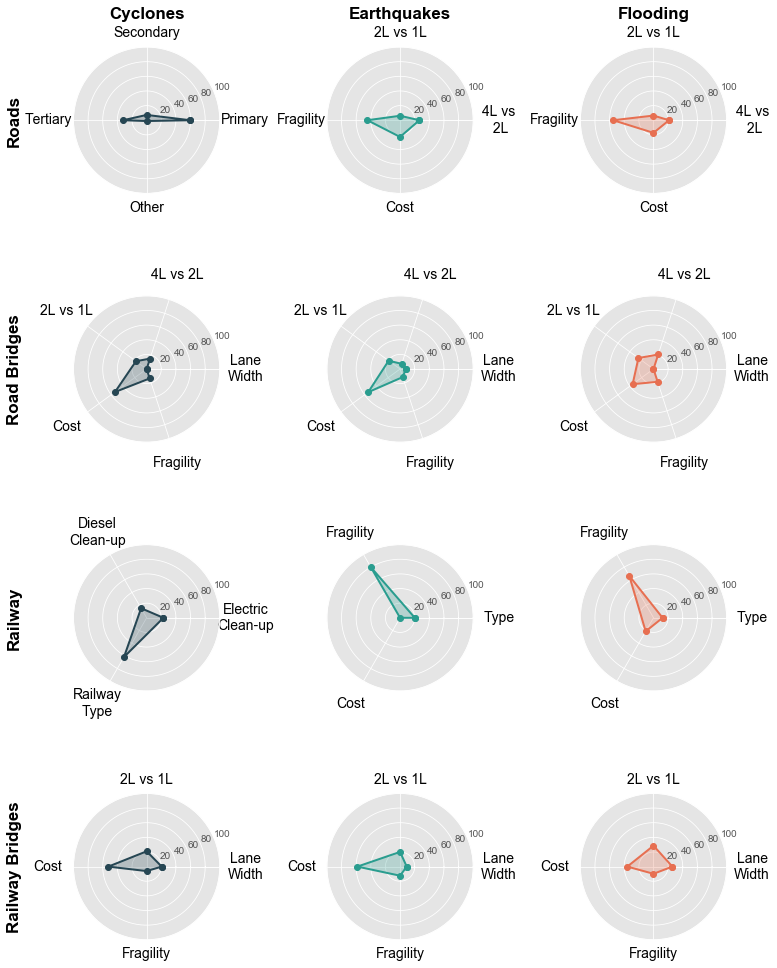

In [6]:
hazards = ['EQ','Cyc','PU','FU','CF']
hazards_full = ['Cyclones','Earthquakes','Flooding']
fig, ax_uncerts = plt.subplots(4, 3,figsize=(11,15),subplot_kw=dict(projection='polar'))

#                               gridspec_kw={'wspace': 0.8, 'hspace': 0.05}) #

color_scheme_map = ['#264653','#2A9D8F','#E76F51']*4 

for iter_,ax in enumerate(ax_uncerts.flat):

    # ROADS
    if iter_ == 0:
        param_values = [np.fromfile(os.path.join(data_path,'input_data','param_values_Cyc.pkl'))[x:x+4] for x in range(0, len(np.fromfile(os.path.join(data_path,'input_data','param_values_Cyc.pkl'))), 4)]
        problem = {
          'num_vars': 4,
          'names': ['x1', 'x2', 'x3','x4'],
          'bounds': [[5000,50000],[1000,10000],[500,5000],[0,500]]}

        Si = SALib.analyze.morris.analyze(problem, np.array(param_values), 
                                          np.array([sum(i) for i in zip(*df_Cyc['risk'])]),
                                     print_to_console=False, grid_jump=2, num_levels=4)    
    elif iter_ == 1:
        param_values = [np.fromfile(os.path.join(data_path,'input_data','param_values_EQ.pkl'))[x:x+4] for x in range(0, len(np.fromfile(os.path.join(data_path,'input_data','param_values_EQ.pkl'))), 4)]
        problem = {
          'num_vars': 4,
          'names': ['x1', 'x2', 'x3','x4'],
          'bounds': [[0,1],[0,1],[0,3],[0.75,1.25]]}

        Si = SALib.analyze.morris.analyze(problem, np.array(param_values), 
                                          np.array([sum(i) for i in zip(*df_EQ['risk'])]),
                                     print_to_console=False, grid_jump=2, num_levels=4)
    elif iter_ == 2:
        param_values = [np.fromfile(os.path.join(data_path,'input_data','param_values.pkl'))[x:x+4] for x in range(0, len(np.fromfile(os.path.join(data_path,'input_data','param_values.pkl'))), 4)]
        problem = {
          'num_vars': 4,
          'names': ['x1', 'x2', 'x3','x4'],
          'bounds': [[0,1],[0,1],[0,3],[0.75,1.25]]}

        Si = SALib.analyze.morris.analyze(problem, np.array(param_values), 
                                          (np.array([sum(i) for i in zip(*df_PU['risk'])])+
                                          np.array([sum(i) for i in zip(*df_FU['risk'])])+
                                          np.array([sum(i) for i in zip(*df_CF['risk'])])),
                                     print_to_console=False, grid_jump=2, num_levels=4)
    #ROAD BRIDGES
    elif iter_ == 3:
        param_values = [np.fromfile(os.path.join(data_path,'input_data','param_values_bridges_road.pkl'))[x:x+5] 
                        for x in range(0, len(np.fromfile(os.path.join(data_path,'input_data','param_values_bridges_road.pkl'))), 5)]
        problem = {
                  'num_vars': 5,
                  'names': ['width', '4l_2l','2l_1l','cost','fragility'],
                  'bounds': [[2.7,4.6],[0,1],[0,1],[0,1],[1,4]]}
        
        Si = SALib.analyze.morris.analyze(problem, np.array(param_values), 
                                          np.array(list(pd.DataFrame(df_bridges_road['Cyc_risk'].tolist()).sum(axis=0))),
                                     print_to_console=False, grid_jump=2, num_levels=5)    
    elif iter_ == 4:
        param_values = [np.fromfile(os.path.join(data_path,'input_data','param_values_bridges_road.pkl'))[x:x+5] 
                        for x in range(0, len(np.fromfile(os.path.join(data_path,'input_data','param_values_bridges_road.pkl'))), 5)]
        problem = {
                  'num_vars': 5,
                  'names': ['width', '4l_2l','2l_1l','cost','fragility'],
                  'bounds': [[2.7,4.6],[0,1],[0,1],[0,1],[1,4]]}
        
        Si = SALib.analyze.morris.analyze(problem, np.array(param_values), 
                                          np.array(list(pd.DataFrame(df_bridges_road['EQ_risk'].tolist()).sum(axis=0))),
                                     print_to_console=False, grid_jump=2, num_levels=5)
    elif iter_ == 5:
        param_values = [np.fromfile(os.path.join(data_path,'input_data','param_values_bridges_road.pkl'))[x:x+5] 
                        for x in range(0, len(np.fromfile(os.path.join(data_path,'input_data','param_values_bridges_road.pkl'))), 5)]
        problem = {
                  'num_vars': 5,
                  'names': ['width', '4l_2l','2l_1l','cost','fragility'],
                  'bounds': [[2.7,4.6],[0,1],[0,1],[0,1],[1,4]]}

        Si = SALib.analyze.morris.analyze(problem, np.array(param_values), 
                                          (np.array(list(pd.DataFrame(df_bridges_road['PU_risk'].tolist()).sum(axis=0)))+
                                          np.array(list(pd.DataFrame(df_bridges_road['FU_risk'].tolist()).sum(axis=0)))+
                                          np.array(list(pd.DataFrame(df_bridges_road['CF_risk'].tolist()).sum(axis=0)))),
                                     print_to_console=False, grid_jump=2, num_levels=5)

        
    #RAILWAY
    elif iter_ == 6:
        param_values = [np.fromfile(os.path.join(data_path,'input_data','param_values_cyc_rail.pkl'))[x:x+3] 
                                for x in range(0, len(np.fromfile(os.path.join(data_path,'input_data','param_values_cyc_rail.pkl'))), 3)]
        problem = {
          'num_vars': 3,
          'names': ['x1', 'x2', 'x3'],
          'bounds': [[5000,50000],[1000,10000],[0,1]]}

        Si = SALib.analyze.morris.analyze(problem, np.array(param_values), 
                                          np.array([sum(i) for i in zip(*df_Cyc_rail['risk'])]),
                                     print_to_console=False, grid_jump=2, num_levels=4)    
    elif iter_ == 7:
        param_values = [np.fromfile(os.path.join(data_path,'input_data','param_values_eq_rail.pkl'))[x:x+3] 
                                for x in range(0, len(np.fromfile(os.path.join(data_path,'input_data','param_values_eq_rail.pkl'))), 3)]
        problem = {
          'num_vars': 3,
          'names': ['x1', 'x2', 'x3'],
          'bounds': [[0,1],[1,4],[0.75,1.25]]}
        
        Si = SALib.analyze.morris.analyze(problem, np.array(param_values), 
                                          np.array([sum(i) for i in zip(*df_EQ_rail['risk'])]),
                                     print_to_console=False, grid_jump=2, num_levels=4)
    elif iter_ == 8:
        param_values = [np.fromfile(os.path.join(data_path,'input_data','param_values_fl_rail.pkl'))[x:x+3] 
                    for x in range(0, len(np.fromfile(os.path.join(data_path,'input_data','param_values_fl_rail.pkl'))), 3)]
        
        problem = {
          'num_vars': 3,
          'names': ['x1', 'x2', 'x3'],
          'bounds': [[0,1],[1,5],[0.75,1.25]]}
        
        Si = SALib.analyze.morris.analyze(problem, np.array(param_values), 
                                          (np.array([sum(i) for i in zip(*df_PU_rail['risk'])])+
                                          np.array([sum(i) for i in zip(*df_FU_rail['risk'])])+
                                          np.array([sum(i) for i in zip(*df_CF_rail['risk'])])),
                                     print_to_console=False, grid_jump=2, num_levels=4)
        
    #RAILWAY BRIDGES
    elif iter_ == 9:
        param_values = [np.fromfile(os.path.join(data_path,'input_data','param_values_bridges_rail.pkl'))[x:x+4] 
                        for x in range(0, len(np.fromfile(os.path.join(data_path,'input_data','param_values_bridges_rail.pkl'))), 4)]
        problem = {
              'num_vars': 4,
              'names': ['width','2l_1l','cost','fragility'],
              'bounds': [[3,5],[0,1],[0,1],[1,4]]}

        Si = SALib.analyze.morris.analyze(problem, np.array(param_values), 
                                          np.array(list(pd.DataFrame(df_bridges_rail['Cyc_risk'].tolist()).sum(axis=0))),
                                     print_to_console=False, grid_jump=2, num_levels=4)   
    elif iter_ == 10:
        param_values = [np.fromfile(os.path.join(data_path,'input_data','param_values_bridges_rail.pkl'))[x:x+4] 
                        for x in range(0, len(np.fromfile(os.path.join(data_path,'input_data','param_values_bridges_rail.pkl'))), 4)]
        problem = {
              'num_vars': 4,
              'names': ['width','2l_1l','cost','fragility'],
              'bounds': [[3,5],[0,1],[0,1],[1,4]]}
        Si = SALib.analyze.morris.analyze(problem, np.array(param_values), 
                                          np.array(list(pd.DataFrame(df_bridges_rail['EQ_risk'].tolist()).sum(axis=0))),
                                     print_to_console=False, grid_jump=2, num_levels=4)

    elif iter_ == 11:
        param_values = [np.fromfile(os.path.join(data_path,'input_data','param_values_bridges_rail.pkl'))[x:x+4] 
                        for x in range(0, len(np.fromfile(os.path.join(data_path,'input_data','param_values_bridges_rail.pkl'))), 4)]
        problem = {
              'num_vars': 4,
              'names': ['width','2l_1l','cost','fragility'],
              'bounds': [[3,5],[0,1],[0,1],[1,4]]}

        Si = SALib.analyze.morris.analyze(problem, np.array(param_values), 
                                          (np.array(list(pd.DataFrame(df_bridges_rail['PU_risk'].tolist()).sum(axis=0)))+
                                          np.array(list(pd.DataFrame(df_bridges_rail['FU_risk'].tolist()).sum(axis=0)))+
                                          np.array(list(pd.DataFrame(df_bridges_rail['CF_risk'].tolist()).sum(axis=0)))),
                                     print_to_console=False, grid_jump=2, num_levels=4)
                                          
    risk_sens = pd.DataFrame.from_dict(Si)

    risk_sens['rel'] = abs(risk_sens['mu'])/abs(risk_sens['mu']).sum()*100
    risk_sens['mu'] = risk_sens['mu']
    risk_sens = risk_sens.groupby('names').sum()
    risk_sens = risk_sens.T
    
    if (iter_ == 0):
        risk_sens.columns = ['Primary', 'Secondary', 'Tertiary', 'Other']
    elif (iter_ == 1)  | (iter_ == 2) :
        risk_sens.columns = ['4L vs\n 2L', '2L vs 1L', 'Fragility', 'Cost']    
    elif (iter_ == 3) | (iter_ == 4) | (iter_ == 5):
        risk_sens.columns =['Lane\nWidth', '4L vs 2L','2L vs 1L','Cost','Fragility']
    elif (iter_ == 6) :
        risk_sens.columns = ['Electric\nClean-up', 'Diesel\nClean-up', 'Railway\nType']    
    elif (iter_ == 7) | (iter_ == 8):
        risk_sens.columns = ['Type', 'Fragility', 'Cost']    
    elif (iter_ == 9)  | (iter_ == 10) | (iter_ == 11):
        risk_sens.columns = ['Lane\nWidth', '2L vs 1L', 'Cost', 'Fragility']

    stats=risk_sens.loc['rel',np.array(risk_sens.columns)].values

    angles=np.linspace(0, 2*np.pi, len(np.array(risk_sens.columns)), endpoint=False)
    
    # close the plot
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))

    ax.plot(angles, stats, 'o-', linewidth=2,color=color_scheme_map[iter_])
    ax.set_ylim([0, 100])   
    ax.fill(angles, stats, alpha=0.25,color=color_scheme_map[iter_])
    ax.set_thetagrids(angles * 180/np.pi, np.array(risk_sens.columns))
    ax.tick_params(axis='x',labelsize=14,labelcolor='black',color='black',) # pad=12

    if (iter_ == 0):
        ax.set_ylabel('Roads',fontweight='bold',color='black',fontsize=17)
    elif (iter_ == 3):
        ax.set_ylabel('Road Bridges',fontweight='bold',color='black',fontsize=17)        
    elif (iter_ == 6):
        ax.set_ylabel('Railway',fontweight='bold',color='black',fontsize=17)        
    elif(iter_ == 9):
        ax.set_ylabel('Railway Bridges',fontweight='bold',color='black',fontsize=17)
    
    ax.get_yaxis().set_label_coords(-.35,.5)
        
    for i_,tick in enumerate(ax.get_xaxis().get_major_ticks()):
        if  ((i_ == 3)) & ((iter_ < 3) | (iter_ > 8)): 
            continue
        elif  ((i_ == 1)) & ((iter_ < 3) | (iter_ > 8)): 
            continue
        else:
            tick.set_pad(15.)
            tick.label1 = tick._get_text1()
 
    if iter_ < 3:
        ax.set_title(hazards_full[iter_], y=1.15,fontweight='bold',fontsize=17)
    ax.grid(True)

fig.tight_layout()
fig.subplots_adjust(hspace=0.01)
plt.savefig(os.path.join(data_path,'Figures','Fig7_sensitivity.png'),dpi=400, bbox_inches='tight')

In [7]:
angles * 180/np.pi

array([  0.,  90., 180., 270.,   0.])